### Semantic features as word embeddings

In [4]:
import numpy as np
import os
import torch
import json
from tqdm import tqdm
import scipy

### Semantic features

In [5]:
min_len_line = 5
N_SEMANTIC_FEATURES = 25
semantic_features = {}

def dump_mitchell_web_semantic_features(raw_file = os.path.join("data","mitchell_semantic_raw.txt")):
    with open(raw_file, "r") as datafile:
        lines = datafile.readlines()
        word = None

        for line in lines:

            # Skip empty
            if len(line) >= min_len_line:

                # New feature
                if "Features for" in line:

                    # Discard invalid ones (once fully parsed)
                    if word and len(semantic_features[word]['features']) < N_SEMANTIC_FEATURES: del semantic_features[word] 
                        
                    word = line.split("<a name=\"")[1].split("\"")[0]
                    semantic_features[word] = { "features": [], "values": []}

                elif word:
                    feature_name = line.split("(")[0]
                    val = float(line.split("(")[1].split(")")[0])
                    semantic_features[word]["features"].append(feature_name)
                    semantic_features[word]["values"].append(val)

    # Save to file
    with open(os.path.join('data', 'mitchell_semantic_features.json'), 'w') as fp:
        json.dump(semantic_features, fp)

    return semantic_features

In [6]:
semantic_features = dump_mitchell_web_semantic_features()

### fMRI data

In [7]:
def get_mitchell_original_data(subject = 1, random_voxels = None):
    mdata = scipy.io.loadmat(os.path.join("data", "mitchell", f"mitchell_subject_{subject}.mat"))
    subject_data = {}

    # 6 x 60 trials
    for i in range(mdata["data"][:].shape[0]):
        cond, cond_number, word, word_number, epoch = [x[0] for x in mdata["info"][0][i]]

        # Set trial data
        if epoch[0] not in subject_data: subject_data[epoch[0]] = {}

        if random_voxels:
            random_voxels_idx = np.random.choice(mdata["data"][i][0][0].shape[0], random_voxels)
            subject_data[epoch[0]][word] = mdata["data"][i][0][0][random_voxels_idx]
        else: subject_data[epoch[0]][word] = mdata["data"][i][0][0]

    return subject_data

In [8]:
epoch = 1
fmriData = get_mitchell_original_data(subject=1)[epoch]

### Predicting

In [9]:
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge, Lasso, LinearRegression

from tqdm import tqdm
from numpy import dot
from numpy.linalg import norm

def cosim(a, b):
    return dot(a, b)/(norm(a)*norm(b))

In [10]:
def compute_fold_accuracy(predictors, X_test, y_test, selected_voxels):

    p1 = np.array([predictor.predict([X_test[0]])[0] for predictor in predictors])[selected_voxels]
    p2 = np.array([predictor.predict([X_test[1]])[0] for predictor in predictors])[selected_voxels]
    i1, i2 = y_test[:, selected_voxels] # 0, 1

    # True positives
    tp1 = int(cosim(p1, i1) > cosim(p1, i2))
    tp2 = int(cosim(p2, i1) < cosim(p2, i2))

    return (tp1 + tp2) / 2

In [12]:
k_folds = 30
n_samples = len(semantic_features.keys())

assert n_samples % k_folds == 0, "Number of folds must divide the samples in equal parts. Choose a valid multiplier."

samples_per_fold = (n_samples // k_folds)
n_voxels = fmriData["bell"].shape[0]
THRESHOLD = 0.2
accuracies = []
voxels_amounts = []

n_samples, samples_per_fold, n_voxels

(60, 2, 21764)

In [13]:
for i in tqdm(range(k_folds)):

    # Extracting filtered (most stable voxels) training set
    train_indices = np.array(list(range(samples_per_fold * i)) + list(range((samples_per_fold * (i+1)), n_samples)), dtype=np.int32)
    test_indices = np.array(list(range((samples_per_fold * i), samples_per_fold * (i + 1))), dtype=np.int32)

    # Building train set
    X = []
    Y = []

    for word in semantic_features.keys():
        if word in fmriData.keys():
            x = np.array(semantic_features[word]["values"])
            y = np.array(fmriData[word])

            X.append(x)
            Y.append(y)

    X = np.array(X)
    Y = np.array(Y)

    # Train-test split
    X_train, X_test, y_train, y_test = X[train_indices], X[test_indices], Y[train_indices], Y[test_indices]
    
    # Normalization based on train data
    normalizer = StandardScaler()
    normalizer.fit(X_train)

    X_train = normalizer.transform(X_train)
    X_test = normalizer.transform(X_test)

    # Predicting & scoring
    predictors = [LinearRegression() for i in range(n_voxels)]
    scores = []

    # One predictor per voxel
    j = 0
    for model in predictors:
        model.fit(X_train, y_train[:, j])
        scores.append(model.score(X_test, y_test[:, j]))
        j += 1

    # Select voxels by R2 score and compute 2 words accuracy
    scores = np.array(scores)
    voxel_indices = np.where(scores > THRESHOLD)[0]
    
    voxels_amounts.append(voxel_indices.shape[0])
    accuracies.append(compute_fold_accuracy(predictors, X_test, y_test, voxel_indices))

np.mean(accuracies), np.mean(voxels_amounts)


100%|██████████| 30/30 [11:55<00:00, 23.86s/it]


(0.9833333333333333, 2282.766666666667)

**Observation**

In this case fitting is way more expensive, as 21k voxels are considered.

Test RDMs R^2:	PearsonRResult(statistic=0.2513283612045005, pvalue=1.2630500791038043e-49)


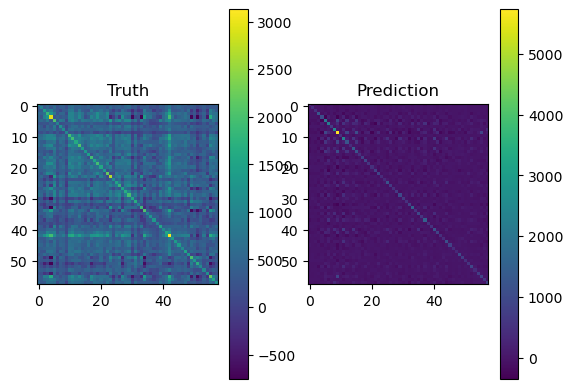

In [14]:
from scipy.stats import pearsonr
import matplotlib.pyplot as plt

def best_K_predict(X, indices, predictors):
    predictors = [predictors[idx] for idx in indices]
    y_hat = np.array([predictor.predict(X) for predictor in predictors]) # voxels, sample
    return y_hat.reshape(y_hat.shape[1], y_hat.shape[0]) # sample, voxels


y_hat = best_K_predict(X_train, voxel_indices, predictors)
y = y_train[:, voxel_indices]

RDM_hat = np.matmul(y_hat, np.matrix.transpose(y_hat))

RDM = np.matmul(y, np.matrix.transpose(y))

test_pearson = pearsonr(
    RDM_hat.flatten(),
    RDM.flatten()
)

print(f"Test RDMs R^2:\t{test_pearson}")

plt.subplot(121)
plt.title("Truth")
plt.imshow(RDM)
plt.colorbar()

plt.subplot(122)
plt.title("Prediction")
plt.imshow(RDM_hat)
plt.colorbar()

**Observation**

Here the the voxels from the last cross_val iteration have been selected. For these voxels, the object to object distance matrices have similar patterns.